In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.special import gamma
from tabulate import tabulate
from time import time

In [2]:
european_call_ref = 0.056832
variance_swap_price_ref = 0.028295
variance_call_price_ref = 0.013517

In [3]:
S_n_const = "S_n"
V_n_const = "V_n"
X_n_const = "X_n"

In [310]:
M = 1

l = 0.3
nu = 0.3
theta = 0.02
rho = -0.7
H = 0.1

K = 1

V_0 = 0.02
S_0 = 1
Y_0 = np.log(S_0)

In [311]:
t_0 = 0
T = 1

In [356]:
number_of_iterations = 8
n_initial = 4

In [313]:
def K_t(t):
    #return np.log(1+1/(t+1))

    if t == 0:
        return 0
    
    return t**(H-0.5)/gamma(H+0.5)

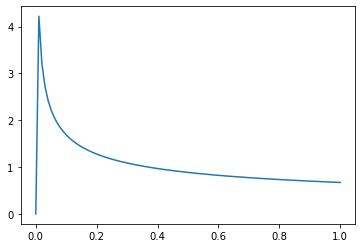

In [314]:
n = 100
t = [k*T/(n-1) for k in range(n)]
K_arr = []

for k in range(np.size(t)):
    K_arr.append(K_t(t[k]))
    
    if K_arr[k]<0:
        print(f"Problem is here: K({t[k]})={K_arr[k]}")
    
plt.plot(t,K_arr)
plt.show()

In [368]:
def european_call_options(x):
    if type(x) != np.ndarray and type(x) != list:
        raise Exception(f"type(x) != list\n type(x)={type(x)}")
        
    #return x[-1]
    return np.maximum(x[-1]-K,0)

def asian_options(x):
    A_T = T*np.mean(x)
    
    return np.maximum(A_T-K,0)

def lookback_options(x):
    M_T = np.max(x)
    
    return np.maximum(M_T-K,0)

def variance_swap_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return x[-1]
        
    return x

def variance_call_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return np.maximum(x[-1]-V_0,0)
        
    return np.maximum(x-V_0,0)

In [316]:
def plot_estimations(scheme_8_data, scheme_9_data, title="E[f(S,X)]", ref_value=None):
    integers1toN = scheme_8_data['n']
    
    fig, ax = plt.subplots()

    s = 1 #todo
    
    ax.plot(integers1toN, scheme_8_data['U_M'], label='Scheme (8)', color="blue")
    ax.fill_between(integers1toN, np.array(scheme_8_data['U_M']) - s*np.array(scheme_8_data['error']), 
                    np.array(scheme_8_data['U_M']) + s*np.array(scheme_8_data['error']), label='Confidence interval', 
                    color='blue', alpha=.1)
    
    ax.plot(integers1toN, scheme_9_data['U_M'], label='Scheme (9)', color="orange")
    ax.fill_between(integers1toN, np.array(scheme_9_data['U_M']) - s*np.array(scheme_9_data['error']), 
                    np.array(scheme_9_data['U_M']) + s*np.array(scheme_9_data['error']), label='Confidence interval', 
                    color='orange', alpha=.1)

    if ref_value != None:
        ax.axhline(ref_value, label='reference value', color="green", linestyle='--')
    
    ax.legend(loc=1)
    
    plt.title(f"Estimation of {title}")
    plt.xlabel("Number of steps")
    plt.ylabel("Estimation")
    
    plt.show()

    
def show_numerical_results_table(scheme_8_results, scheme_9_results, ref_value=None):
    #TODO init constants
    table_size = np.size(scheme_8_results['U_M'])
    
    print("\tEstimation of E[f] with Scheme (8) (left) and Scheme (9) (right).")
    print()
    print("\tMean Value\t Stat.Error\t Comp.Time\t||\t Mean Value\t Stat.Error\t Comp.Time")
    
    if ref_value != None:
        print(f"Ref\t {ref_value}")
        print()
        
    for k in range(table_size):
        print(f"n={scheme_8_results['n'][k]}\t",
            f"{scheme_8_results['U_M'][k]:f}\t",
            f"{scheme_8_results['error'][k]:f}\t",
            f"{scheme_8_results['time'][k]:f}\t||\t",
            f"{scheme_9_results['U_M'][k]:f}\t",
            f"{scheme_9_results['error'][k]:f}\t",
            f"{scheme_9_results['time'][k]:f}")


In [317]:
def stats_n(data):

    U_M = np.mean(data)
    var_M = np.var(data)
    
    error = 2*var_M/np.sqrt(M)
    confidence_interval = [U_M - error, U_M + error]

    return {"U_M": U_M,
            "var_M": var_M,
            "error": error,
            "confidence_interval": confidence_interval}

$$W_{\frac{t_{i+1}+t_i}{2}}\sim\mathcal{N}\big(\frac{W_{i+1}+W_i}{2},\frac{t_{i+1}-t_i}{4}\big)$$

In [318]:
def generate_subdivision(t):

    t_size = np.size(t)
    t_temp = t
    
    for k in range(0,t_size-1):
        t = np.insert(t,2*k+1,(t_temp[k+1]+t_temp[k])/2)
        
    return t

def generate_BM(t,W,W_orth,n=n_initial):

    if np.size(W)==0 or np.size(W_orth)==0:
        if np.size(t) != n:
            raise Exception(f"np.size(t) != n_initial\n np.size(t)={np.size(t)},n_initial={n}")
            
        G1 = np.random.randn(n)
        G2 = np.random.randn(n)
        
        W.append(0)
        W_orth.append(0)
        
        for i in range(n-1):
            W.append(W[i] + np.sqrt(t[i+1] - t[i])*G1[i])
            W_orth.append(W_orth[i] + np.sqrt(t[i+1] - t[i])*G2[i])
            #print(W)
        
        return W, W_orth

    W_temp = W
    W_orth_temp = W_orth
    
    N = np.size(t)
    
    t_delta = t[2]-t[0]

    for i in range(1,N,2):
        
        W_k = np.random.normal((W[i-1]+W[i])/2, t_delta/4) #(t[i+1]-t[i-1])/4)
        W_orth_k = np.random.normal((W_orth[i-1]+W_orth[i])/2, t_delta/4)#(t[i+1]-t[i-1])/4)
        
        W_temp.insert(i,W_k)
        W_orth_temp.insert(i,W_orth_k)


    return W_temp, W_orth_temp

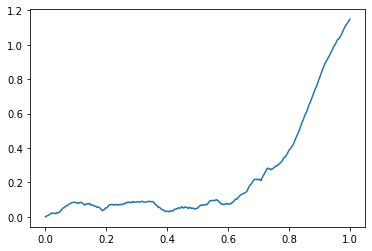

In [319]:
n_test=4
t_test = [k*T/(n_test-1) for k in range(n_test)]
w1,w2=generate_BM(t_test,[],[],n_test)

for i in range(10):
    #print(t_test)
    #print(w1)
    #print(np.size(w1))
    t_test=generate_subdivision(t_test)
    w1,w2=generate_BM(t_test,w1,w2)
    #plt.plot(t_test,w1)
    #plt.show()

_=plt.plot(t_test,w1)

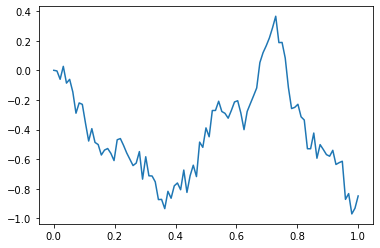

In [320]:
n_test=97
t_test = [k*T/(n_test-1) for k in range(n_test)]
w,_=generate_BM(t_test,[],[],n_test)

plt.plot(t_test,w)

$$
\bar{X}_t:=\max_{0\leq s\leq t}X_s,\\
    M_{t_k}^n=\sum_{i=1}^k\sqrt{\bar{X}_{t_i}^n-\bar{X}_{t_{i-1}}^n}Z_i, \quad M_{t_k}^{n\bot}=\sum_{i=1}^k\sqrt{\bar{X}_{t_i}^n-\bar{X}_{t_{i-1}}^n}Z_i^\bot, \\
Y_{t_k}^n=Y_0-\frac{1}{2}\bar{X}_{t_k}^n+\rho M_{t_k}^n+\sqrt{1-\rho^2}M_{t_k}^{n\bot}, \\
    X_{t_k}^n=V_0t_k+\sum_{i=0}^{k-1}K(t_k-t_i)\bigg(\theta t_i-\lambda\bar{X}_{t_i}^n+\nu M_{t_i}^n\bigg)\Delta t_i^n, \\
    S_{t_k}^n=\exp(Y_{t_k}^n).
$$

$$
Z_i,Z_i^\bot\sim\mathcal{N}(0,1)
$$

In [321]:
def S_X_process(t,Z,Z_orth):
    
    n = np.size(t)
    
    Y_n = np.zeros(n)
    X_n = np.zeros(n)
    X_n_max = np.zeros(n)
    
    S_n = np.zeros(n)

    M_n = np.zeros(n)
    M_n_orth = np.zeros(n)

    Y_n[0] = Y_0
    S_n[0] = S_0
   
    t_delta = t[1] - t[0]
        
    for k in range(n):

        # X is OK
        X_sum = 0
        for i in range(k):
            #X_sum += (theta*t[i] - l*X_n_max[i] + nu*M_n[i])*t_delta*K_t(t[k] - t[i])
            X_sum += (-l*X_n_max[i] + nu*M_n[i])*t_delta*K_t(t[k] - t[i])

        K_integral = integrate.quad(lambda s: theta*s*K_t(t[k]-s), 0, t[k])[0]
        
        X_n[k] = V_0*t[k] + X_sum + K_integral
        X_n_max[k] = np.max(X_n)

        for i in range(1,k+1):
            M_n[k] += np.sqrt(X_n_max[i] - X_n_max[i-1])*Z[i]
            M_n_orth[k] += np.sqrt(X_n_max[i] - X_n_max[i-1])*Z_orth[i]
        
        # Y is not OK
        Y_n[k] = Y_0 - 0.5*X_n_max[k] + rho*M_n[k] + np.sqrt(1 - rho**2)*M_n_orth[k]
        S_n[k] = np.exp(Y_n[k])
        
        
    return {"S_n": S_n,
            "X_n": X_n}


In [348]:
def generate_Z(n,Z,Z_orth):
        
    if n == np.size(Z):
        return Z, Z_orth
    
    if np.size(Z) == 0 or np.size(Z_orth) == 0:
        Z = np.random.normal(0,1,n)
        Z_orth = np.random.normal(0,1,n)
        
        return Z, Z_orth

    j = 1
    for i in range(1,n,2):
        Z = np.insert(Z, j, np.random.normal(0,1))
        Z_orth = np.insert(Z_orth, j, np.random.normal(0,1))
        j+=2
        
        
    return Z, Z_orth

def scheme_9(f, variable, n=None):
    
    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    Z_M = [0]*M
    Z_orth_M = [0]*M

    for m in range(M):
        Z, Z_orth = generate_Z(np.size(t),[],[])

        Z_M[m] = Z
        Z_orth_M[m] = Z_orth
        
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}

    evaluate = None
        
    for n in range(iterations):

        t_0 = time()

        f_n_M = np.zeros(M)
        
        for m in range(M):
            result_sv = S_X_process(t,Z_M[m],Z_orth_M[m])

            S_n = result_sv["S_n"]
            X_n = result_sv["X_n"]

            if variable == S_n_const:
                evaluate = S_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)
            
            Z_M[m], Z_orth_M[m] = generate_Z(2*np.size(t)-1,Z_M[m],Z_orth_M[m])
        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))
        
        t = generate_subdivision(t)


    integers1toN = np.arange(1,iterations+1)
    cum_sum_n = np.cumsum(final_result["U_M"])/integers1toN

    final_result['cum_sum_n'] = cum_sum_n

    return final_result

In [364]:
def scheme_8(f, variable, n=None):

    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    W_M = [0]*M
    W_orth_M = [0]*M

    for m in range(M):
        W, W_orth = generate_BM(t,[],[])

        W_M[m] = W
        W_orth_M[m] = W_orth
 
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}
    evaluate = None
    
    for n in range(iterations):

        t_0 = time()

        t_delta = t[1]-t[0]

        f_n_M = np.zeros(M)

        for m in range(M):
            #print(m,W_M[m])
            result_sv = S_V_process(t,W_M[m],W_orth_M[m])

            S_n = result_sv["S_n"]
            V_n = result_sv["V_n"]
            X_n = sum(V_n)*t_delta
            #print(S_n)
            
            if variable == S_n_const:
                evaluate = S_n
            elif variable == V_n_const:
                evaluate = V_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)

            t_new = generate_subdivision(t)
            W_M[m], W_orth_M[m] = generate_BM(t_new,W_M[m],W_orth_M[m])

        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))

        t = generate_subdivision(t)

    integers1toN = np.arange(1,iterations+1)
    cum_sum_n = np.cumsum(final_result["U_M"])/integers1toN

    final_result['cum_sum_n'] = cum_sum_n

    return final_result

In [353]:
def S_V_process(t,W,W_orth):

    n = np.size(t)

    Y_n = np.zeros(n)
    V_n = np.zeros(n)
    S_n = np.zeros(n)

    S_n[0] = S_0
    Y_n[0] = Y_0
    V_n[0] = V_0

    t_delta = t[1] - t[0]

    #print(W)
    for k in range(1,n):

        # V is OK
        V_sum = 0
        for i in range(k):
            #print(i,k)
            #V_sum += ((K_t(t[k]-t[i])*((theta - l*np.maximum(V_n[i],0))*t_delta
            #         + nu*np.sqrt(np.maximum(V_n[i],0))*(W[i+1] - W[i]))))
            #print(W)
            V_sum += ((K_t(t[k]-t[i])*(-l*np.maximum(V_n[i],0)*t_delta
                     + nu*np.sqrt(np.maximum(V_n[i],0))*(W[i+1] - W[i]))))

        K_integral = integrate.quad(lambda s: theta*K_t(t[k]-s), 0, t[k])[0]
        V_n[k] = V_0 + V_sum + K_integral

        # Y is OK
        Y_sum = 0
        for i in range(k):
            Y_sum += (-0.5*np.maximum(V_n[i],0)*t_delta + rho*np.sqrt(np.maximum(V_n[i],0))*(W[i+1] - W[i]) 
                  + np.sqrt(1 - rho**2)*np.sqrt(np.maximum(V_n[i],0))*(W_orth[i+1] - W_orth[i]))

        Y_n[k] = Y_0 + Y_sum
        S_n[k] = np.exp(Y_n[k])


    return {"V_n": V_n,
            "S_n": S_n}


## _European call_ maximum(S_T-K,0)

In [371]:
scheme_8_results = scheme_8(european_call_options, S_n_const) #CONVERGES!
scheme_9_results = scheme_9(european_call_options, S_n_const) #ne zbs
#Getting different results (9th seems to be closer to the truth)

#For fixed n=49 0.056328 0.058179
#Problem with refinement: n=49	 0.039976 0.057779

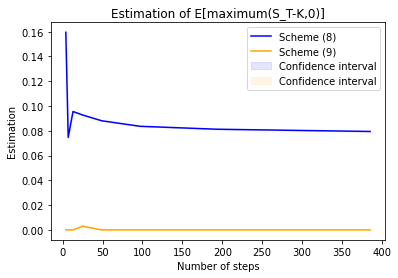

	Estimation of E[f] with Scheme (8) (left) and Scheme (9) (right).

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.056832

n=4	 0.159569	 0.000000	 0.006610	||	 0.000000	 0.000000	 0.001011
n=7	 0.074693	 0.000000	 0.009077	||	 0.000000	 0.000000	 0.002407
n=13	 0.095580	 0.000000	 0.020638	||	 0.000000	 0.000000	 0.004894
n=25	 0.092795	 0.000000	 0.023352	||	 0.003014	 0.000000	 0.010251
n=49	 0.088115	 0.000000	 0.040663	||	 0.000000	 0.000000	 0.022812
n=97	 0.083657	 0.000000	 0.095593	||	 0.000000	 0.000000	 0.055484
n=193	 0.081290	 0.000000	 0.317197	||	 0.000000	 0.000000	 0.147372
n=385	 0.079477	 0.000000	 1.141377	||	 0.000000	 0.000000	 0.448625


In [372]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(S_T-K,0)]")
show_numerical_results_table(scheme_8_results ,scheme_9_results, european_call_ref)

## _Asian option_ maximum(A_T-K,0)

In [362]:
scheme_8_results = scheme_8(asian_options, S_n_const) #CONVERGES!
scheme_9_results = scheme_9(asian_options, S_n_const)
#Getting different results
#For fixed n=49 0.032868 0.031239
#Problem with refinement: n=49	 0.020580 0.031766

[1.         0.86423242 0.92176    0.90872889]
[1.         0.94206393 0.83390614 0.86095921 0.88714185 0.88796597
 0.87074481]
[1.         0.98080235 0.93784773 0.8942316  0.81631805 0.82098002
 0.84170173 0.87404575 0.87064813 0.86947631 0.8715156  0.85784752
 0.85206712]
[1.         0.98451337 0.98014785 0.9573884  0.93389662 0.91568982
 0.88685512 0.85087057 0.80493988 0.80148576 0.8092928  0.81790724
 0.82885943 0.84762275 0.85696615 0.85376044 0.85325483 0.85325228
 0.85201996 0.85200502 0.85417023 0.84692112 0.83973289 0.83575818
 0.83381162]
[1.         0.99153445 0.98346452 0.98231106 0.9794122  0.96601878
 0.95523123 0.94499057 0.92928087 0.92105088 0.91010812 0.89425407
 0.88023697 0.86304729 0.84290944 0.81979161 0.79476504 0.79419801
 0.79132266 0.79384524 0.79895848 0.80371268 0.80719879 0.81413541
 0.81799231 0.82610649 0.83472029 0.8387276  0.8438148  0.84167868
 0.84048231 0.84275747 0.84006534 0.84183891 0.84013704 0.83769665
 0.83892189 0.83933815 0.83888109 0.84033106

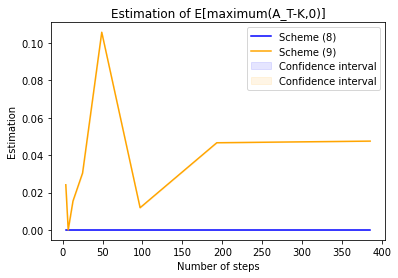

	Estimation of E[f] with Scheme (8) (left) and Scheme (9) (right).

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 -

n=4	 0.000000	 0.000000	 0.005895	||	 0.024135	 0.000000	 0.001025
n=7	 0.000000	 0.000000	 0.009077	||	 0.000000	 0.000000	 0.002423
n=13	 0.000000	 0.000000	 0.012789	||	 0.015443	 0.000000	 0.004924
n=25	 0.000000	 0.000000	 0.024083	||	 0.030416	 0.000000	 0.010232
n=49	 0.000000	 0.000000	 0.042291	||	 0.105689	 0.000000	 0.022824
n=97	 0.000000	 0.000000	 0.096259	||	 0.011867	 0.000000	 0.055144
n=193	 0.000000	 0.000000	 0.319300	||	 0.046608	 0.000000	 0.148641
n=385	 0.000000	 0.000000	 1.192991	||	 0.047480	 0.000000	 0.452993


In [363]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(A_T-K,0)]") 
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Lookback option_ maximum(M_T-K,0)


In [298]:
scheme_8_results = scheme_8(lookback_options, S_n_const) #duze ne zbs
scheme_9_results = scheme_9(lookback_options, S_n_const) #zbs
#Getting different results for refinement: n=49	 0.055984 0.094127
#For fixed n=49: 0.090724 0.091100

#fixed n=49	 0.058998 0.087911

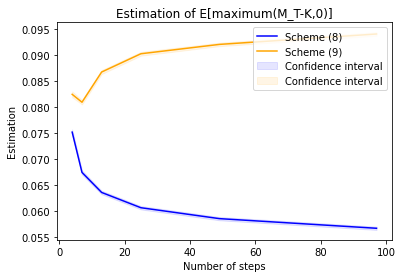

	Estimation of E[f] with Scheme (8) (left) and Scheme (9) (right).

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 -

n=4	 0.075194	 0.000519	 0.901908	||	 0.082439	 0.000559	 0.993420
n=7	 0.067470	 0.000388	 2.335829	||	 0.080922	 0.000424	 2.446346
n=13	 0.063632	 0.000340	 5.148180	||	 0.086712	 0.000384	 4.981857
n=25	 0.060702	 0.000326	 12.189297	||	 0.090218	 0.000367	 10.446593
n=49	 0.058611	 0.000319	 32.134143	||	 0.092011	 0.000336	 23.197444
n=97	 0.056763	 0.000314	 95.487080	||	 0.094005	 0.000336	 56.132282


In [299]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(M_T-K,0)]")
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Variance swap price_ E[X_t]

In [300]:
scheme_8_results = scheme_8(variance_swap_price, X_n_const) #8th converges to sth
scheme_9_results = scheme_9(variance_swap_price, X_n_const) #9th seems to converge to sth
# for fixed n=100 both schemes converges to ~0.0244

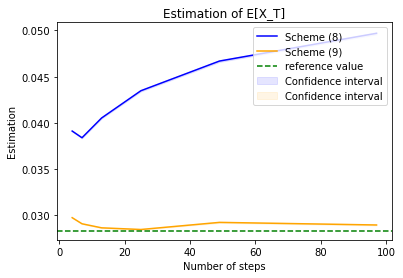

	Estimation of E[f] with Scheme (8) (left) and Scheme (9) (right).

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.028295

n=4	 0.039124	 0.000051	 0.900816	||	 0.029760	 0.000023	 0.997258
n=7	 0.038401	 0.000055	 2.344643	||	 0.029101	 0.000034	 2.456288
n=13	 0.040539	 0.000066	 5.176382	||	 0.028662	 0.000041	 5.073145
n=25	 0.043483	 0.000081	 12.282684	||	 0.028482	 0.000045	 10.478706
n=49	 0.046690	 0.000098	 32.764935	||	 0.029252	 0.000062	 23.184676
n=97	 0.049693	 0.000112	 96.690145	||	 0.028971	 0.000059	 56.779910


In [301]:
plot_estimations(scheme_8_results, scheme_9_results, "E[X_T]", variance_swap_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_swap_price_ref)

## _Variance call price_ E[maximum(X_T-V_0,0)]

In [302]:
scheme_8_results = scheme_8(variance_call_price, X_n_const) #8th converges to sthing
scheme_9_results = scheme_9(variance_call_price, X_n_const) #9th not good
# for fixed n=100 both schemes converges to 0.013213 0.013164
# sth wrong with refinement: n=97	 0.026338 0.016566

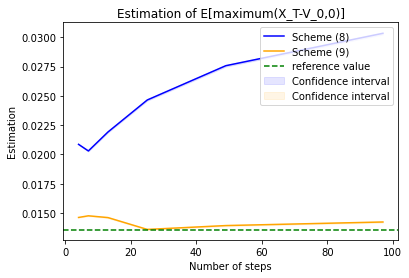

	Estimation of E[f] with Scheme (8) (left) and Scheme (9) (right).

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.013517

n=4	 0.020863	 0.000038	 0.900422	||	 0.014623	 0.000018	 0.989696
n=7	 0.020298	 0.000042	 2.340739	||	 0.014764	 0.000028	 2.433107
n=13	 0.021918	 0.000052	 5.158662	||	 0.014612	 0.000042	 4.979186
n=25	 0.024648	 0.000065	 12.242779	||	 0.013601	 0.000042	 10.464579
n=49	 0.027572	 0.000078	 32.204922	||	 0.013931	 0.000049	 23.271847
n=97	 0.030336	 0.000091	 95.740748	||	 0.014237	 0.000050	 56.608868


In [303]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(X_T-V_0,0)]", variance_call_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_call_price_ref)